# Team A3. Muyuan Chen & Lijuan Liu






In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
path = "/content/gdrive/My Drive/project_ensemble"
os.chdir(path)
print("Working Directory:", os.getcwd())


Mounted at /content/gdrive
Working Directory: /content/gdrive/My Drive/project_ensemble


In [ ]:
# import  packages you need
!pip install recordlinkage
import pandas as pd
import numpy as np
from google.colab import drive
import recordlinkage as rl, pandas as pd, numpy as np
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
from recordlinkage.preprocessing import phonetic
from numpy.random import choice
import collections, numpy
from IPython.display import clear_output
from sklearn.model_selection import train_test_split, KFold
from typing import Tuple, List, Dict

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.9/926.9 kB 17.3 MB/s eta 0:00:00


### FEBRL Database

In [ ]:
import recordlinkage as rl
import pandas as pd
from recordlinkage.datasets import load_febrl3, load_febrl4
from IPython.display import clear_output

def load_and_preprocess_data(dataset_loader, dataset_name):
    # Load data based on the dataset loader provided
    if dataset_name == 'febrl4':
        df_a, df_b, true_links_ab = dataset_loader(return_links=True)
        df = pd.concat([df_a, df_b])
    else:  # For febrl3
        df, true_links_ab = dataset_loader(return_links=True)

    # Process date of birth
    df['date_of_birth'] = pd.to_datetime(df['date_of_birth'], errors='coerce')
    df[['day', 'month', 'year']] = df['date_of_birth'].dt.strftime('%d-%m-%Y').str.split('-', expand=True)

    # Process numeric fields
    for col in ['postcode', 'street_number']:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

    # Process string fields
    string_cols = ["surname", "given_name", "address_1", "address_2", "day", "month"]
    df[string_cols] = df[string_cols].fillna('').astype(str)

    # Phonetic encoding for names
    df['given_name_soundex'] = phonetic(df['given_name'], method='soundex')
    df['given_name_nysiis'] = phonetic(df['given_name'], method='nysiis')
    df['surname_soundex'] = phonetic(df['surname'], method='soundex')
    df['surname_nysiis'] = phonetic(df['surname'], method='nysiis')

    # Drop unnecessary columns
    df = df.drop(["soc_sec_id", "date_of_birth"], axis=1)

    return df, true_links_ab

def assign_match_ids(df, true_links_ab):
    df['match_id'] = -1
    for i, (k0, k1) in enumerate(true_links_ab):
        df.loc[df.index.isin([k0, k1]), 'match_id'] = i
        print(f"Processed: {i}", end='\r')
        clear_output(wait=True)
    print("Match ID assignment completed.")

# def perform_blocking(df):
#     indexer = rl.Index()
#     indexer.block(["given_name", "surname", "postcode"])
#     candidate_links = indexer.index(df)
#     return candidate_links

def extract_features(df, links):
    compare = rl.Compare()
    compare.string('given_name', 'given_name', method='jarowinkler', label='name_sim')
    compare.string('surname', 'surname', method='jarowinkler', label='surname_sim')
    compare.exact('street_number', 'street_number', label='street_number_sim')
    compare.string('address_1', 'address_1', method='levenshtein', threshold=0.7, label='address_sim')
    compare.exact('postcode', 'postcode', label='postcode_sim')
    compare.exact('day', 'day', label='day_sim')
    compare.exact('month', 'month', label='month_sim')
    compare.exact('year', 'year', label='year_sim')

    features = compare.compute(links, df)
    return features
def save_to_csv(df, filename, index=True, header=True, date_format='%Y-%m-%d'):
    df.to_csv(filename, index=index, header=header, date_format=date_format)
    print(f"Data saved to {filename}")

def main():
    datasets = {
        'febrl3': load_febrl3,
        'febrl4': load_febrl4
    }

    for name, loader in datasets.items():
        print(f"Processing {name} dataset...")
        df, true_links_ab = load_and_preprocess_data(loader, name)

        all_fields = df.columns.values.tolist()
        print(f"All fields for {name}:", all_fields)
        print(df.head())

        assign_match_ids(df, true_links_ab)

        # candidate_links = perform_blocking(df)
        # print(f"Number of candidate links after blocking: {len(candidate_links)}")

        # features = extract_features(df, candidate_links)
        # print("Feature extraction completed.")

        save_to_csv(df, f"{name}_UNSW.csv")
        # save_to_csv(features, f"{name}_features_UNSW.csv")

if __name__ == "__main__":
    main()



Match ID assignment completed.
Data saved to febrl4_UNSW.csv


In [ ]:
import recordlinkage as rl, pandas as pd, numpy as np
def generate_true_links(df):
    # although the match_id column is included in the original df to imply the true links,
    # this function will create the true_link object identical to the true_links properties
    # of recordlinkage toolkit, in order to exploit "Compare.compute()" from that toolkit
    # in extract_function() for extracting features quicker.
    # This process should be deprecated in the future release of the UNSW toolkit.
    df["rec_id"] = df.index.values.tolist()
    indices_1 = []
    indices_2 = []
    processed = 0
    for match_id in df["match_id"].unique():
        if match_id != -1:
            processed = processed + 1
            # print("In routine generate_true_links(), count =", processed)
            # clear_output(wait=True)
            linkages = df.loc[df['match_id'] == match_id]
            for j in range(len(linkages)-1):
                for k in range(j+1, len(linkages)):
                    indices_1 = indices_1 + [linkages.iloc[j]["rec_id"]]
                    indices_2 = indices_2 + [linkages.iloc[k]["rec_id"]]
    links = pd.MultiIndex.from_arrays([indices_1,indices_2])
    return links

def generate_false_links(df, size):
    # A counterpart of generate_true_links(), with the purpose to generate random false pairs
    # for training. The number of false pairs in specified as "size".
    df["rec_id"] = df.index.values.tolist()
    indices_1 = []
    indices_2 = []
    unique_match_id = df["match_id"].unique()
    for j in range(size):
            false_pair_ids = choice(unique_match_id, 2)
            candidate_1_cluster = df.loc[df['match_id'] == false_pair_ids[0]]
            candidate_1 = candidate_1_cluster.iloc[choice(range(len(candidate_1_cluster)))]
            candidate_2_cluster = df.loc[df['match_id'] == false_pair_ids[1]]
            candidate_2 = candidate_2_cluster.iloc[choice(range(len(candidate_2_cluster)))]
            indices_1 = indices_1 + [candidate_1["rec_id"]]
            indices_2 = indices_2 + [candidate_2["rec_id"]]
    links = pd.MultiIndex.from_arrays([indices_1,indices_2])
    return links

def swap_fields_flag(f11, f12, f21, f22):
    return int((f11 == f22) and (f12 == f21))

def extract_features(df, links):
    c = rl.Compare()
    c.string('given_name', 'given_name', method='jarowinkler', label='y_name')
    c.string('given_name_soundex', 'given_name_soundex', method='jarowinkler', label='y_name_soundex')
    c.string('given_name_nysiis', 'given_name_nysiis', method='jarowinkler', label='y_name_nysiis')
    c.string('surname', 'surname', method='jarowinkler', label='y_surname')
    c.string('surname_soundex', 'surname_soundex', method='jarowinkler', label='y_surname_soundex')
    c.string('surname_nysiis', 'surname_nysiis', method='jarowinkler', label='y_surname_nysiis')
    c.exact('street_number', 'street_number', label='y_street_number')
    c.string('address_1', 'address_1', method='levenshtein', threshold=0.7, label='y_address1')
    c.string('address_2', 'address_2', method='levenshtein', threshold=0.7, label='y_address2')
    c.exact('postcode', 'postcode', label='y_postcode')
    c.exact('day', 'day', label='y_day')
    c.exact('month', 'month', label='y_month')
    c.exact('year', 'year', label='y_year')

    # Build features
    feature_vectors = c.compute(links, df, df)
    return feature_vectors

def generate_train_X_y(df):
    # This routine is to generate the feature vector X and the corresponding labels y
    # with exactly equal number of samples for both classes to train the classifier.
    pos = extract_features(df, train_true_links)
    train_false_links = generate_false_links(df, len(train_true_links))
    neg = extract_features(df, train_false_links)
    X = pos.values.tolist() + neg.values.tolist()
    y = [1]*len(pos)+[0]*len(neg)
    X, y = shuffle(X, y, random_state=0)
    X = np.array(X)
    y = np.array(y)
    return X, y

def train_model(modeltype, modelparam, train_vectors, train_labels, modeltype_2):
    if modeltype == 'svm': # Support Vector Machine
        model = svm.SVC(C = modelparam, kernel = modeltype_2)
        model.fit(train_vectors, train_labels)
    elif modeltype == 'lg': # Logistic Regression
        model = LogisticRegression(C=modelparam, penalty = modeltype_2,class_weight=None, dual=False, fit_intercept=True,
                                   intercept_scaling=1, max_iter=5000, multi_class='ovr',
                                   n_jobs=1, random_state=None)
        model.fit(train_vectors, train_labels)
    elif modeltype == 'nb': # Naive Bayes
        model = GaussianNB()
        model.fit(train_vectors, train_labels)
    elif modeltype == 'nn': # Neural Network
        model = MLPClassifier(solver='lbfgs', alpha=modelparam, hidden_layer_sizes=(256, ),
                              activation = modeltype_2,random_state=None, batch_size='auto',
                              learning_rate='constant',  learning_rate_init=0.001,
                              power_t=0.5, max_iter=10000, shuffle=True,
                              tol=0.0001, verbose=False, warm_start=False, momentum=0.9,
                              nesterovs_momentum=True, early_stopping=False,
                              validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
        model.fit(train_vectors, train_labels)
    return model

def classify(model, test_vectors):
    result = model.predict(test_vectors)
    return result


def evaluation(test_labels, result):
    true_pos = np.logical_and(test_labels, result)
    count_true_pos = np.sum(true_pos)
    true_neg = np.logical_and(np.logical_not(test_labels),np.logical_not(result))
    count_true_neg = np.sum(true_neg)
    false_pos = np.logical_and(np.logical_not(test_labels), result)
    count_false_pos = np.sum(false_pos)
    false_neg = np.logical_and(test_labels,np.logical_not(result))
    count_false_neg = np.sum(false_neg)
    precision = count_true_pos/(count_true_pos+count_false_pos)
    sensitivity = count_true_pos/(count_true_pos+count_false_neg) # sensitivity = recall
    confusion_matrix = [count_true_pos, count_false_pos, count_false_neg, count_true_neg]
    no_links_found = np.count_nonzero(result)
    no_false = count_false_pos + count_false_neg
    Fscore = 2*precision*sensitivity/(precision+sensitivity)
    metrics_result = {'no_false':no_false, 'confusion_matrix':confusion_matrix ,'precision':precision,
                     'sensitivity':sensitivity ,'no_links':no_links_found, 'F-score': Fscore}
    return metrics_result

def blocking_performance(candidates, true_links, df):
    count = 0
    for candi in candidates:
        if df.loc[candi[0]]["match_id"]==df.loc[candi[1]]["match_id"]:
            count = count + 1
    return count

trainset = 'febrl3_UNSW'
testset = 'febrl4_UNSW'

## TRAIN SET CONSTRUCTION

# Import
print("Import train set...")
df_train = pd.read_csv(trainset+".csv", index_col = "rec_id")
train_true_links = generate_true_links(df_train)
print("Train set size:", len(df_train), ", number of matched pairs: ", str(len(train_true_links)))

# Preprocess train set
df_train['postcode'] = df_train['postcode'].astype(str)
df_train['given_name_soundex'] = phonetic(df_train['given_name'], method='soundex')
df_train['given_name_nysiis'] = phonetic(df_train['given_name'], method='nysiis')
df_train['surname_soundex'] = phonetic(df_train['surname'], method='soundex')
df_train['surname_nysiis'] = phonetic(df_train['surname'], method='nysiis')

# Final train feature vectors and labels
X_train_FRBRL, y_train_FRBRL = generate_train_X_y(df_train)
print("Finished building X_train_FRBRL, y_train_FRBRL")

# Blocking Criteria: declare non-match of all of the below fields disagree
# Import
print("Import test set...")
df_test = pd.read_csv(testset+".csv", index_col = "rec_id")
test_true_links = generate_true_links(df_test)
leng_test_true_links = len(test_true_links)
print("Test set size:", len(df_test), ", number of matched pairs: ", str(leng_test_true_links))

print("BLOCKING PERFORMANCE:")
blocking_fields = ["given_name", "surname", "postcode"]
all_candidate_pairs = []
for field in blocking_fields:
    indexer = rl.Index()
    indexer.block(field)
    candidates = indexer.index(df_test)

    detects = blocking_performance(candidates, test_true_links, df_test)
    all_candidate_pairs = candidates.union(all_candidate_pairs)
    print("Number of pairs of matched "+ field +": "+str(len(candidates)), ", detected ",
         detects,'/'+ str(leng_test_true_links) + " true matched pairs, missed " +
          str(leng_test_true_links-detects) )
detects = blocking_performance(all_candidate_pairs, test_true_links, df_test)
print("Number of pairs of at least 1 field matched: " + str(len(all_candidate_pairs)), ", detected ",
     detects,'/'+ str(leng_test_true_links) + " true matched pairs, missed " +
          str(leng_test_true_links-detects) )

## TEST SET CONSTRUCTION

# Preprocess test set
print("Processing test set...")
print("Preprocess...")
df_test['postcode'] = df_test['postcode'].astype(str)
df_test['given_name_soundex'] = phonetic(df_test['given_name'], method='soundex')
df_test['given_name_nysiis'] = phonetic(df_test['given_name'], method='nysiis')
df_test['surname_soundex'] = phonetic(df_test['surname'], method='soundex')
df_test['surname_nysiis'] = phonetic(df_test['surname'], method='nysiis')

# Test feature vectors and labels construction
print("Extract feature vectors...")
df_X_test = extract_features(df_test, all_candidate_pairs)
vectors = df_X_test.values.tolist()
labels = [0]*len(vectors)
feature_index = df_X_test.index
for i in range(0, len(feature_index)):
    if df_test.loc[feature_index[i][0]]["match_id"]==df_test.loc[feature_index[i][1]]["match_id"]:
        labels[i] = 1
X_test, y_test = shuffle(vectors, labels, random_state=0)
X_test_FRBRL = np.array(X_test)
y_test_FRBRL = np.array(y_test)
print("Count labels of y_test:",collections.Counter(y_test))
print("Finished building X_test_FRBRL, y_test_FRBRL")

Import train set...
Train set size: 5000 , number of matched pairs:  1165
Finished building X_train_FRBRL, y_train_FRBRL
Import test set...
Test set size: 10000 , number of matched pairs:  5000
BLOCKING PERFORMANCE:
Number of pairs of matched given_name: 154898 , detected  3287 /5000 true matched pairs, missed 1713
Number of pairs of matched surname: 170843 , detected  3325 /5000 true matched pairs, missed 1675
Number of pairs of matched postcode: 53197 , detected  4219 /5000 true matched pairs, missed 781
Number of pairs of at least 1 field matched: 372073 , detected  4894 /5000 true matched pairs, missed 106
Processing test set...
Preprocess...
Extract feature vectors...
Count labels of y_test: Counter({0: 367179, 1: 4894})
Finished building X_test_FRBRL, y_test_FRBRL


### ePBRN

In [ ]:


import recordlinkage as rl, pandas as pd, numpy as np
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
from recordlinkage.preprocessing import phonetic
from numpy.random import choice
import collections, numpy
from IPython.display import clear_output
from sklearn.model_selection import train_test_split, KFold


def generate_true_links(df):
    # although the match_id column is included in the original df to imply the true links,
    # this function will create the true_link object identical to the true_links properties
    # of recordlinkage toolkit, in order to exploit "Compare.compute()" from that toolkit
    # in extract_function() for extracting features quicker.
    # This process should be deprecated in the future release of the UNSW toolkit.
    df["rec_id"] = df.index.values.tolist()
    indices_1 = []
    indices_2 = []
    processed = 0
    for match_id in df["match_id"].unique():
        if match_id != -1:
            processed = processed + 1
            # print("In routine generate_true_links(), count =", processed)
            # clear_output(wait=True)
            linkages = df.loc[df['match_id'] == match_id]
            for j in range(len(linkages)-1):
                for k in range(j+1, len(linkages)):
                    indices_1 = indices_1 + [linkages.iloc[j]["rec_id"]]
                    indices_2 = indices_2 + [linkages.iloc[k]["rec_id"]]
    links = pd.MultiIndex.from_arrays([indices_1,indices_2])
    return links

def generate_false_links(df, size):
    # A counterpart of generate_true_links(), with the purpose to generate random false pairs
    # for training. The number of false pairs in specified as "size".
    df["rec_id"] = df.index.values.tolist()
    indices_1 = []
    indices_2 = []
    unique_match_id = df["match_id"].unique()
    unique_match_id = unique_match_id[~np.isnan(unique_match_id)] # remove nan values
    for j in range(size):
            false_pair_ids = choice(unique_match_id, 2)
            candidate_1_cluster = df.loc[df['match_id'] == false_pair_ids[0]]
            candidate_1 = candidate_1_cluster.iloc[choice(range(len(candidate_1_cluster)))]
            candidate_2_cluster = df.loc[df['match_id'] == false_pair_ids[1]]
            candidate_2 = candidate_2_cluster.iloc[choice(range(len(candidate_2_cluster)))]
            indices_1 = indices_1 + [candidate_1["rec_id"]]
            indices_2 = indices_2 + [candidate_2["rec_id"]]
    links = pd.MultiIndex.from_arrays([indices_1,indices_2])
    return links

def swap_fields_flag(f11, f12, f21, f22):
    return ((f11 == f22) & (f12 == f21)).astype(float)

def join_names_space(f11, f12, f21, f22):
    return ((f11+" "+f12 == f21) | (f11+" "+f12 == f22)| (f21+" "+f22 == f11)| (f21+" "+f22 == f12)).astype(float)

def join_names_dash(f11, f12, f21, f22):
    return ((f11+"-"+f12 == f21) | (f11+"-"+f12 == f22)| (f21+"-"+f22 == f11)| (f21+"-"+f22 == f12)).astype(float)

def abb_surname(f1, f2):
    return ((f1[0]==f2) | (f1==f2[0])).astype(float)

def reset_day(f11, f12, f21, f22):
    return (((f11 == 1) & (f12 == 1))|((f21 == 1) & (f22 == 1))).astype(float)

def extract_features(df, links):
    c = rl.Compare()
    c.string('given_name', 'given_name', method='levenshtein', label='y_name_leven')
    c.string('surname', 'surname', method='levenshtein', label='y_surname_leven')
    c.string('given_name', 'given_name', method='jarowinkler', label='y_name_jaro')
    c.string('surname', 'surname', method='jarowinkler', label='y_surname_jaro')
    c.string('postcode', 'postcode', method='jarowinkler', label='y_postcode')
    exact_fields = ['postcode', 'address_1', 'address_2', 'street_number']
    for field in exact_fields:
        c.exact(field, field, label='y_'+field+'_exact')
    c.compare_vectorized(reset_day,('day', 'month'), ('day', 'month'),label='reset_day_flag')
    c.compare_vectorized(swap_fields_flag,('day', 'month'), ('day', 'month'),label='swap_day_month')
    c.compare_vectorized(swap_fields_flag,('surname', 'given_name'), ('surname', 'given_name'),label='swap_names')
    c.compare_vectorized(join_names_space,('surname', 'given_name'), ('surname', 'given_name'),label='join_names_space')
    c.compare_vectorized(join_names_dash,('surname', 'given_name'), ('surname', 'given_name'),label='join_names_dash')
    c.compare_vectorized(abb_surname,'surname', 'surname',label='abb_surname')
    # Build features
    feature_vectors = c.compute(links, df, df)
    return feature_vectors

def generate_train_X_y(df):
    # This routine is to generate the feature vector X and the corresponding labels y
    # with exactly equal number of samples for both classes to train the classifier.
    pos = extract_features(df, train_true_links)
    train_false_links = generate_false_links(df, len(train_true_links))
    neg = extract_features(df, train_false_links)
    X = pos.values.tolist() + neg.values.tolist()
    y = [1]*len(pos)+[0]*len(neg)
    X, y = shuffle(X, y, random_state=0)
    X = np.array(X)
    y = np.array(y)
    return X, y

def train_model(modeltype, modelparam, train_vectors, train_labels, modeltype_2):
    if modeltype == 'svm': # Support Vector Machine
        model = svm.SVC(C = modelparam, kernel = modeltype_2)
        model.fit(train_vectors, train_labels)
    elif modeltype == 'lg': # Logistic Regression
        model = LogisticRegression(C=modelparam, penalty = modeltype_2,class_weight=None, dual=False, fit_intercept=True,
                                   intercept_scaling=1, max_iter=5000, multi_class='ovr',
                                   n_jobs=1, random_state=None)
        model.fit(train_vectors, train_labels)
    elif modeltype == 'nb': # Naive Bayes
        model = GaussianNB()
        model.fit(train_vectors, train_labels)
    elif modeltype == 'nn': # Neural Network
        model = MLPClassifier(solver='lbfgs', alpha=modelparam, hidden_layer_sizes=(256, ),
                              activation = modeltype_2,random_state=None, batch_size='auto',
                              learning_rate='constant',  learning_rate_init=0.001,
                              power_t=0.5, max_iter=30000, shuffle=True,
                              tol=0.0001, verbose=False, warm_start=False, momentum=0.9,
                              nesterovs_momentum=True, early_stopping=False,
                              validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
        model.fit(train_vectors, train_labels)
    return model

def classify(model, test_vectors):
    result = model.predict(test_vectors)
    return result


def evaluation(test_labels, result):
    true_pos = np.logical_and(test_labels, result)
    count_true_pos = np.sum(true_pos)
    true_neg = np.logical_and(np.logical_not(test_labels),np.logical_not(result))
    count_true_neg = np.sum(true_neg)
    false_pos = np.logical_and(np.logical_not(test_labels), result)
    count_false_pos = np.sum(false_pos)
    false_neg = np.logical_and(test_labels,np.logical_not(result))
    count_false_neg = np.sum(false_neg)
    precision = count_true_pos/(count_true_pos+count_false_pos)
    sensitivity = count_true_pos/(count_true_pos+count_false_neg) # sensitivity = recall
    confusion_matrix = [count_true_pos, count_false_pos, count_false_neg, count_true_neg]
    no_links_found = np.count_nonzero(result)
    no_false = count_false_pos + count_false_neg
    Fscore = 2*precision*sensitivity/(precision+sensitivity)
    metrics_result = {'no_false':no_false, 'confusion_matrix':confusion_matrix ,'precision':precision,
                     'sensitivity':sensitivity ,'no_links':no_links_found, 'F-score': Fscore}
    return metrics_result

def blocking_performance(candidates, true_links, df):
    count = 0
    for candi in candidates:
        if df.loc[candi[0]]["match_id"]==df.loc[candi[1]]["match_id"]:
            count = count + 1
    return count


## TRAIN SET CONSTRUCTION
trainset = 'ePBRN_F_dup'
testset = 'ePBRN_D_dup'

# Import
print("Import train set...")
df_train = pd.read_csv(trainset+".csv", index_col = "rec_id")
train_true_links = generate_true_links(df_train)
print("Train set size:", len(df_train), ", number of matched pairs: ", str(len(train_true_links)))

# Preprocess train set
df_train['postcode'] = df_train['postcode'].astype(str)

# Final train feature vectors and labels
X_train, y_train = generate_train_X_y(df_train)
print("Finished building X_train, y_train")

Import train set...
Train set size: 14078 , number of matched pairs:  3192


<ipython-input-11-f31de79c113c>:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return ((f1[0]==f2) | (f1==f2[0])).astype(float)


Finished building X_train, y_train


<ipython-input-11-f31de79c113c>:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return ((f1[0]==f2) | (f1==f2[0])).astype(float)


In [ ]:
# Blocking Criteria: declare non-match of all of the below fields disagree
# Import
print("Import train set...")
df_train = pd.read_csv(trainset+".csv", index_col = "rec_id")
train_true_links = generate_true_links(df_train)
print("Train set size:", len(df_train), ", number of matched pairs: ", str(len(train_true_links)))

# Preprocess train set
df_train['postcode'] = df_train['postcode'].astype(str)

# Final train feature vectors and labels
X_train, y_train = generate_train_X_y(df_train)
print("Finished building X_train, y_train")
print("Import test set...")
df_test = pd.read_csv(testset+".csv", index_col = "rec_id")
test_true_links = generate_true_links(df_test)
leng_test_true_links = len(test_true_links)
print("Test set size:", len(df_test), ", number of matched pairs: ", str(leng_test_true_links))

print("BLOCKING PERFORMANCE:")
blocking_fields = ["given_name", "surname", "postcode"]
all_candidate_pairs = []
for field in blocking_fields:
    indexer = rl.Index()
    indexer.block(field)
    candidates = indexer.index(df_test)
    detects = blocking_performance(candidates, test_true_links, df_test)
    all_candidate_pairs = candidates.union(all_candidate_pairs)
    print("Number of pairs of matched "+ field +": "+str(len(candidates)), ", detected ",
         detects,'/'+ str(leng_test_true_links) + " true matched pairs, missed " +
          str(leng_test_true_links-detects) )
detects = blocking_performance(all_candidate_pairs, test_true_links, df_test)
print("Number of pairs of at least 1 field matched: " + str(len(all_candidate_pairs)), ", detected ",
     detects,'/'+ str(leng_test_true_links) + " true matched pairs, missed " +
          str(leng_test_true_links-detects) )

## TEST SET CONSTRUCTION

# Preprocess test set
print("Processing test set...")
print("Preprocess...")
df_test['postcode'] = df_test['postcode'].astype(str)

# Test feature vectors and labels construction
print("Extract feature vectors...")
df_X_test = extract_features(df_test, all_candidate_pairs)
vectors = df_X_test.values.tolist()
labels = [0]*len(vectors)
feature_index = df_X_test.index
for i in range(0, len(feature_index)):
    if df_test.loc[feature_index[i][0]]["match_id"]==df_test.loc[feature_index[i][1]]["match_id"]:
        labels[i] = 1
X_test, y_test = shuffle(vectors, labels, random_state=0)
X_test = np.array(X_test)
y_test = np.array(y_test)
print("Count labels of y_test:",collections.Counter(y_test))
print("Finished building X_test, y_test")


Import train set...
Train set size: 14078 , number of matched pairs:  3192


<ipython-input-11-f31de79c113c>:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return ((f1[0]==f2) | (f1==f2[0])).astype(float)
<ipython-input-11-f31de79c113c>:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return ((f1[0]==f2) | (f1==f2[0])).astype(float)


Finished building X_train, y_train
Import test set...
Test set size: 11731 , number of matched pairs:  2653
BLOCKING PERFORMANCE:
Number of pairs of matched given_name: 252552 , detected  1567 /2653 true matched pairs, missed 1086
Number of pairs of matched surname: 33832 , detected  1480 /2653 true matched pairs, missed 1173
Number of pairs of matched postcode: 79940 , detected  2462 /2653 true matched pairs, missed 191
Number of pairs of at least 1 field matched: 362910 , detected  2599 /2653 true matched pairs, missed 54
Processing test set...
Preprocess...
Extract feature vectors...


<ipython-input-11-f31de79c113c>:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return ((f1[0]==f2) | (f1==f2[0])).astype(float)


Count labels of y_test: Counter({0: 360311, 1: 2599})
Finished building X_test, y_test


In [ ]:
## BASE LEARNERS CLASSIFICATION AND EVALUATION，Scheme A，FERBL
# choice model for svm，lg，nn

from sklearn.model_selection import KFold
import numpy as np

model_configs = [
    {'modeltype': 'svm', 'modeltype_2': 'rbf', 'param_range': 0.05},
    {'modeltype': 'lg', 'modeltype_2': 'l2', 'param_range': 0.02},
    {'modeltype': 'nn', 'modeltype_2': 'relu', 'param_range': 100}
]
# Base Learners Performance Evaluation
for config in model_configs:
    modeltype = config['modeltype']
    modeltype_2 = config['modeltype_2']
    modelparam_range = config['param_range']

    print("BASE LEARNERS CLASSIFICATION PERFORMANCE:")
    print("Model:", modeltype, ", Param_1:", modeltype_2, ", tuning range:", modelparam_range)

    precision, sensitivity, Fscore, nb_false = [], [], [], []

    # Train and evaluate model on X_test
    md = train_model(modeltype, modelparam_range, X_train_FRBRL, y_train_FRBRL, modeltype_2)
    final_result = classify(md, X_test_FRBRL)
    final_eval = evaluation(y_test_FRBRL, final_result)

    # Append results for the current hyperparameter
    precision.append(final_eval['precision'])
    Fscore.append(final_eval['F-score'])
    nb_false.append(final_eval['no_false'])
    sensitivity.append(final_eval['sensitivity'])

    print(f"\nParam: {modelparam_range}")
    print("Precision:", precision)
    print("Sensitivity", sensitivity)
    print("F-score:", Fscore)
    print("No_false:", nb_false)


BASE LEARNERS CLASSIFICATION PERFORMANCE:
Model: svm , Param_1: rbf , tuning range: 0.05

Param: 0.05
Precision: [0.3900183369209918]
Sensitivity [0.9995913363302003]
F-score: [0.5611056947869473]
No_false: [7653]
BASE LEARNERS CLASSIFICATION PERFORMANCE:
Model: lg , Param_1: l2 , tuning range: 0.02

Param: 0.02
Precision: [0.9715082685793983]
Sensitivity [0.9963220269718022]
F-score: [0.9837587006960555]
No_false: [161]
BASE LEARNERS CLASSIFICATION PERFORMANCE:
Model: nn , Param_1: relu , tuning range: 100


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



Param: 100
Precision: [0.9647873392680514]
Sensitivity [0.996526358806702]
F-score: [0.9804000402050458]
No_false: [195]



BASE LEARNERS CLASSIFICATION PERFORMANCE:
Model: svm, Param_1: rbf, tuning range: 0.05
Precision: 0.3900183369209918
Sensitivity (Recall): 0.9995913363302003
F-score: 0.5611056947869473
Accuracy: 0.9794314556552074
No_false: 7653
Confusion Matrix:
[[359528   7651]
 [     2   4892]]

BASE LEARNERS CLASSIFICATION PERFORMANCE:
Model: lg, Param_1: l2, tuning range: 0.02


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Precision: 0.9715082685793983
Sensitivity (Recall): 0.9963220269718022
F-score: 0.9837587006960555
Accuracy: 0.9995672892147509
No_false: 161
Confusion Matrix:
[[367036    143]
 [    18   4876]]

BASE LEARNERS CLASSIFICATION PERFORMANCE:
Model: nn, Param_1: relu, tuning range: 100
Precision: 0.9645965189873418
Sensitivity (Recall): 0.996526358806702
F-score: 0.9803015075376884
Accuracy: 0.9994732216527402
No_false: 196
Confusion Matrix:
[[367000    179]
 [    17   4877]]


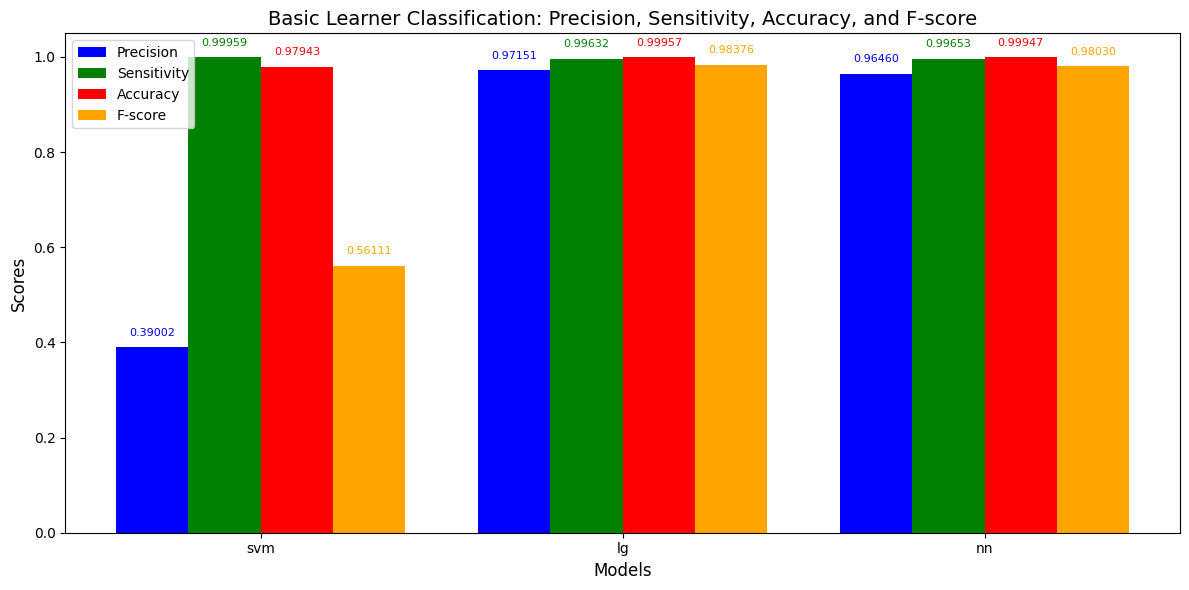

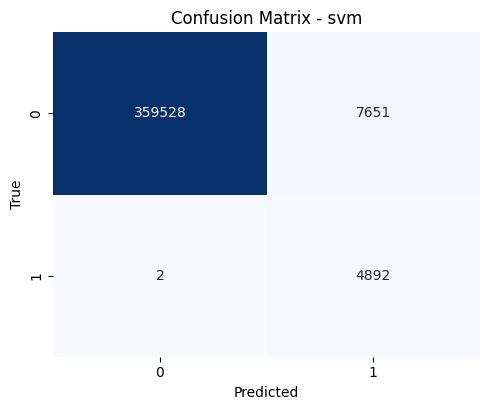

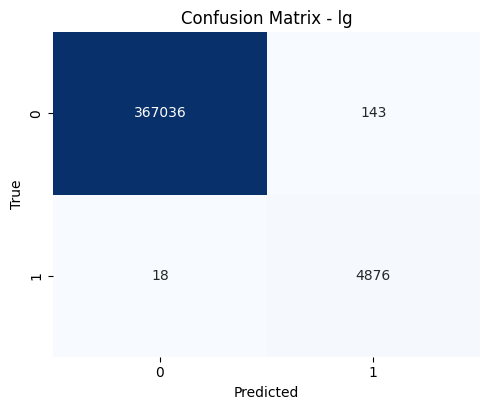

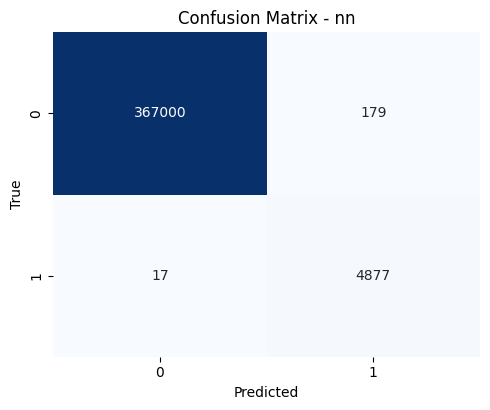

In [ ]:
# basic learn curve FERBL
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

model_configs = [
    {'modeltype': 'svm', 'modeltype_2': 'rbf', 'param_range': 0.05},
    {'modeltype': 'lg', 'modeltype_2': 'l2', 'param_range': 0.02},
    {'modeltype': 'nn', 'modeltype_2': 'relu', 'param_range': 100}
]

# Initialize lists for plotting
model_names = []
precisions = []
sensitivities = []
Fscores = []
accuracies = []
confusion_matrices = []

# Base Learners Performance Evaluation
for config in model_configs:
    modeltype = config['modeltype']
    modeltype_2 = config['modeltype_2']
    modelparam_range = config['param_range']

    print("\nBASE LEARNERS CLASSIFICATION PERFORMANCE:")
    print(f"Model: {modeltype}, Param_1: {modeltype_2}, tuning range: {modelparam_range}")

    # Train and evaluate model on X_test
    md = train_model(modeltype, modelparam_range, X_train_FRBRL, y_train_FRBRL, modeltype_2)
    final_result = classify(md, X_test_FRBRL)
    final_eval = evaluation(y_test_FRBRL, final_result)

    # Append results for the current model
    precision = final_eval['precision']
    sensitivity = final_eval['sensitivity']
    Fscore = final_eval['F-score']
    nb_false = final_eval['no_false']
    acc = accuracy_score(y_test_FRBRL, final_result)

    precisions.append(precision)
    sensitivities.append(sensitivity)
    Fscores.append(Fscore)
    accuracies.append(acc)
    model_names.append(modeltype)

    # Generate confusion matrix
    cm = confusion_matrix(y_test_FRBRL, final_result)
    confusion_matrices.append(cm)

    # Print results
    print(f"Precision: {precision}")
    print(f"Sensitivity (Recall): {sensitivity}")
    print(f"F-score: {Fscore}")
    print(f"Accuracy: {acc}")
    print(f"No_false: {nb_false}")
    print(f"Confusion Matrix:\n{cm}")

# Plot Precision, Sensitivity, Accuracy, and F-score as bar charts
x = np.arange(len(model_names))
width = 0.2

plt.figure(figsize=(12, 6))

plt.bar(x - 1.5*width, precisions, width, label='Precision', color='blue')
plt.bar(x - 0.5*width, sensitivities, width, label='Sensitivity', color='green')
plt.bar(x + 0.5*width, accuracies, width, label='Accuracy', color='red')
plt.bar(x + 1.5*width, Fscores, width, label='F-score', color='orange')


for i in range(len(model_names)):
    # Precision
    plt.text(x[i] - 1.5*width, precisions[i] + 0.02, f"{precisions[i]:.5f}", ha='center', va='bottom', color='blue', fontsize=8)
    # Sensitivity，
    plt.text(x[i] - 0.5*width, sensitivities[i] + 0.02, f"{sensitivities[i]:.5f}", ha='center', va='bottom', color='green', fontsize=8)
    # Accuracy
    plt.text(x[i] + 0.5*width, accuracies[i] + 0.02, f"{accuracies[i]:.5f}", ha='center', va='bottom', color='red', fontsize=8)
    # F-score，
    plt.text(x[i] + 1.5*width, Fscores[i] + 0.02, f"{Fscores[i]:.5f}", ha='center', va='bottom', color='orange', fontsize=8)


plt.xticks(x, model_names, fontsize=10)
plt.xlabel("Models", fontsize=12)
plt.ylabel("Scores", fontsize=12)
plt.title("Basic Learner Classification: Precision, Sensitivity, Accuracy, and F-score", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


for i, cm in enumerate(confusion_matrices):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 10})
    plt.title(f"Confusion Matrix - {model_names[i]}", fontsize=12)
    plt.xlabel("Predicted", fontsize=10)
    plt.ylabel("True", fontsize=10)
    plt.tight_layout(rect=[0, -0.05, 1, 1])
    plt.show()

BAGGING PERFORMANCE:

Fold 1 Results - Model: svm, Param: 0.005
svm bagging: {'no_false': 218, 'confusion_matrix': [4877, 201, 17, 366978], 'precision': 0.9604174871996849, 'sensitivity': 0.996526358806702, 'no_links': 5078, 'F-score': 0.9781387886081025}
Fold 2 Results - Model: svm, Param: 0.005
svm bagging: {'no_false': 306, 'confusion_matrix': [4877, 289, 17, 366890], 'precision': 0.9440572977158344, 'sensitivity': 0.996526358806702, 'no_links': 5166, 'F-score': 0.969582504970179}
Fold 3 Results - Model: svm, Param: 0.005
svm bagging: {'no_false': 295, 'confusion_matrix': [4877, 278, 17, 366901], 'precision': 0.9460717749757517, 'sensitivity': 0.996526358806702, 'no_links': 5155, 'F-score': 0.9706438451587222}
Fold 4 Results - Model: svm, Param: 0.005
svm bagging: {'no_false': 238, 'confusion_matrix': [4877, 221, 17, 366958], 'precision': 0.9566496665358964, 'sensitivity': 0.996526358806702, 'no_links': 5098, 'F-score': 0.9761809447558046}
Fold 5 Results - Model: svm, Param: 0.005
s

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre

Fold 5 Results - Model: lg, Param: 0.02
lg bagging: {'no_false': 142, 'confusion_matrix': [4876, 124, 18, 367055], 'precision': 0.9752, 'sensitivity': 0.9963220269718022, 'no_links': 5000, 'F-score': 0.9856478673943804}
Fold 6 Results - Model: lg, Param: 0.02
lg bagging: {'no_false': 160, 'confusion_matrix': [4875, 141, 19, 367038], 'precision': 0.97188995215311, 'sensitivity': 0.9961176951369023, 'no_links': 5016, 'F-score': 0.9838546922300706}
Fold 7 Results - Model: lg, Param: 0.02
lg bagging: {'no_false': 139, 'confusion_matrix': [4876, 121, 18, 367058], 'precision': 0.9757854712827697, 'sensitivity': 0.9963220269718022, 'no_links': 4997, 'F-score': 0.9859468203417249}
Fold 8 Results - Model: lg, Param: 0.02
lg bagging: {'no_false': 167, 'confusion_matrix': [4876, 149, 18, 367030], 'precision': 0.9703482587064677, 'sensitivity': 0.9963220269718022, 'no_links': 5025, 'F-score': 0.9831636253654602}
Fold 9 Results - Model: lg, Param: 0.02
lg bagging: {'no_false': 146, 'confusion_matri

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre

lg bagging: {'no_false': 154, 'confusion_matrix': [4875, 135, 19, 367044], 'precision': 0.9730538922155688, 'sensitivity': 0.9961176951369023, 'no_links': 5010, 'F-score': 0.9844507269789984}

Fold 1 Results - Model: nn, Param: 200
nn bagging: {'no_false': 104, 'confusion_matrix': [4872, 82, 22, 367097], 'precision': 0.9834477190149374, 'sensitivity': 0.9955046996322027, 'no_links': 4954, 'F-score': 0.9894394800974817}
Fold 2 Results - Model: nn, Param: 200
nn bagging: {'no_false': 113, 'confusion_matrix': [4872, 91, 22, 367088], 'precision': 0.9816643159379408, 'sensitivity': 0.9955046996322027, 'no_links': 4963, 'F-score': 0.9885360657400832}
Fold 3 Results - Model: nn, Param: 200
nn bagging: {'no_false': 109, 'confusion_matrix': [4872, 87, 22, 367092], 'precision': 0.9824561403508771, 'sensitivity': 0.9955046996322027, 'no_links': 4959, 'F-score': 0.9889373794783314}
Fold 4 Results - Model: nn, Param: 200
nn bagging: {'no_false': 112, 'confusion_matrix': [4872, 90, 22, 367089], 'pre

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre

Processing Bagging for Model: nn, Param: 200
Stacking Features Shape (Train): (2330, 3)
Stacking Features Shape (Test): (372073, 3)

STACKING FINAL PERFORMANCE:
Accuracy: 0.9997124220247102
Precision: 0.9828525317732499
Sensitivity (Recall): 0.9955046996322027
Recall: 0.9955046996322027
F1-Score: 0.9891381585625825
Confusion Matrix:
[[367094     85]
 [    22   4872]]


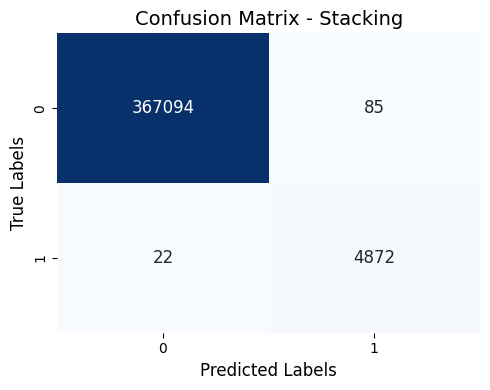

In [ ]:
# Bagging and stakcing，Scheme A，FERBL

print("BAGGING PERFORMANCE:\n")
n_folds = 10
kf = KFold(n_splits=n_folds)

model_configs = [
    {'modeltype': 'svm', 'modeltype_2': 'linear', 'param_range': 0.005},
    {'modeltype': 'lg', 'modeltype_2': 'l2', 'param_range': 0.02},
    {'modeltype': 'nn', 'modeltype_2': 'relu', 'param_range': 200}
]
thres = 0.5
model_raw_scores = []


for config in model_configs:
    modeltype = config['modeltype']
    modeltype_2 = config['modeltype_2']
    modelparam_range = config['param_range']

    fold_precisions, fold_sensitivities, fold_fscores, fold_nb_false = [], [], [], []

    # KFold validation
    for n_folds, (train_index, valid_index) in enumerate(kf.split(X_train_FRBRL), start=1):
        X_train_fold = X_train_FRBRL[train_index]
        y_train_fold = y_train_FRBRL[train_index]
        md = train_model(modeltype, modelparam_range, X_train_fold, y_train_fold, modeltype_2)
        final_result = classify(md, X_test_FRBRL)
        final_eval = evaluation(y_test_FRBRL, final_result)

        model_raw_scores.append(final_result)

        fold_precisions.append(final_eval['precision'])
        fold_sensitivities.append(final_eval['sensitivity'])
        fold_fscores.append(final_eval['F-score'])
        fold_nb_false.append(final_eval['no_false'])
        print(f"Fold {n_folds} Results - Model: {modeltype}, Param: {modelparam_range}")
        print(modeltype, "bagging:", final_eval)



    avg_precision = np.mean(fold_precisions)
    avg_fscore = np.mean(fold_fscores)
    avg_nb_false = np.mean(fold_nb_false)

    print(f"Fold {n_folds} Results - Model: {modeltype}, Param: {modelparam_range}")
    print(f"  Precision: {final_eval['precision']}")
    print(f"  Sensitivity: {final_eval['sensitivity']}")
    print(f"  F-score: {final_eval['F-score']}")
    print(f"  No_false: {final_eval['no_false']}\n")

    bagging_raw_score = np.mean(model_raw_scores, axis=0)
    bagging_binary_score  = np.copy(bagging_raw_score)
    bagging_binary_score[bagging_binary_score > thres] = 1
    bagging_binary_score[bagging_binary_score <= thres] = 0
    bagging_eval = evaluation(y_test_FRBRL, bagging_binary_score)
    print(modeltype, "bagging:", bagging_eval)
    print('')


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

print("BAGGING + STACKING PERFORMANCE:\n")
n_folds = 10
kf = KFold(n_splits=n_folds)

model_configs = [
    {'modeltype': 'svm', 'modeltype_2': 'linear', 'param_range': 0.001},
    {'modeltype': 'lg', 'modeltype_2': 'l2', 'param_range': 0.005},
    {'modeltype': 'nn', 'modeltype_2': 'relu', 'param_range': 200}
]
thres = 0.5


stacking_features_train = []
stacking_features_test = []

for config in model_configs:
    modeltype = config['modeltype']
    modeltype_2 = config['modeltype_2']
    modelparam_range = config['param_range']

    print(f"Processing Bagging for Model: {modeltype}, Param: {modelparam_range}")

    bagging_raw_scores_test = []
    fold_valid_preds = np.zeros(X_train_FRBRL.shape[0])


    for n_folds, (train_index, valid_index) in enumerate(kf.split(X_train_FRBRL), start=1):
        X_train_fold, X_valid_fold = X_train_FRBRL[train_index], X_train_FRBRL[valid_index]
        y_train_fold, y_valid_fold = y_train_FRBRL[train_index], y_train_FRBRL[valid_index]


        md = train_model(modeltype, modelparam_range, X_train_fold, y_train_fold, modeltype_2)


        valid_preds = classify(md, X_valid_fold)
        fold_valid_preds[valid_index] = valid_preds


        test_preds = classify(md, X_test_FRBRL)
        bagging_raw_scores_test.append(test_preds)

    bagging_raw_score_test = np.mean(bagging_raw_scores_test, axis=0)
    stacking_features_test.append(bagging_raw_score_test)

    stacking_features_train.append(fold_valid_preds)


stacking_features_train = np.column_stack(stacking_features_train)
stacking_features_test = np.column_stack(stacking_features_test)

print("Stacking Features Shape (Train):", stacking_features_train.shape)
print("Stacking Features Shape (Test):", stacking_features_test.shape)


meta_learner = LogisticRegression(random_state=42, max_iter=200)

meta_learner.fit(stacking_features_train, y_train_FRBRL)

y_pred = meta_learner.predict(stacking_features_test)


accuracy = accuracy_score(y_test_FRBRL, y_pred)
precision = precision_score(y_test_FRBRL, y_pred)
recall = recall_score(y_test_FRBRL, y_pred)
f1 = f1_score(y_test_FRBRL, y_pred)
sensitivity = recall

print("\nSTACKING FINAL PERFORMANCE:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Sensitivity (Recall): {sensitivity}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")


cm = confusion_matrix(y_test_FRBRL, y_pred)
print(f"Confusion Matrix:\n{cm}")

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 12})
plt.title('Confusion Matrix - Stacking', fontsize=14)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.tight_layout()
plt.show()



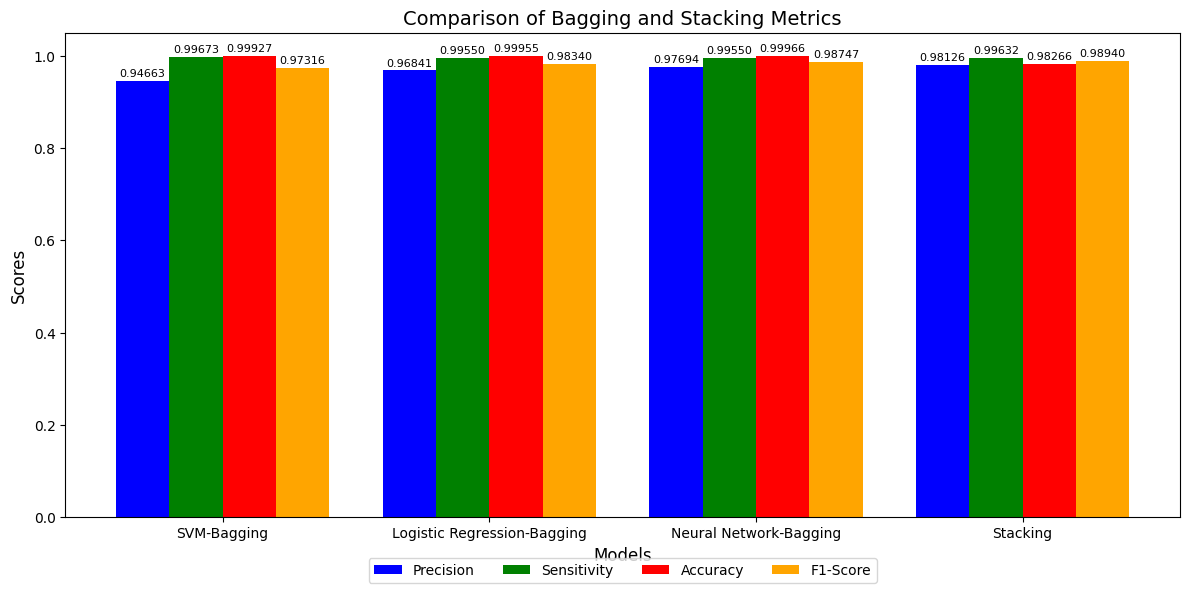

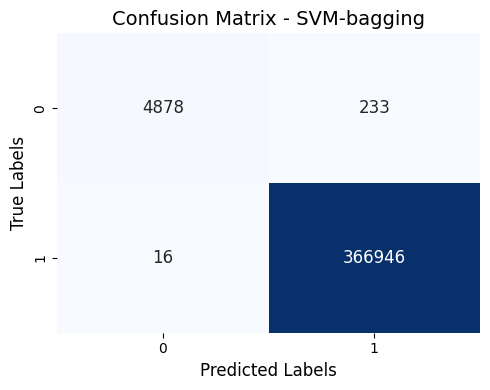

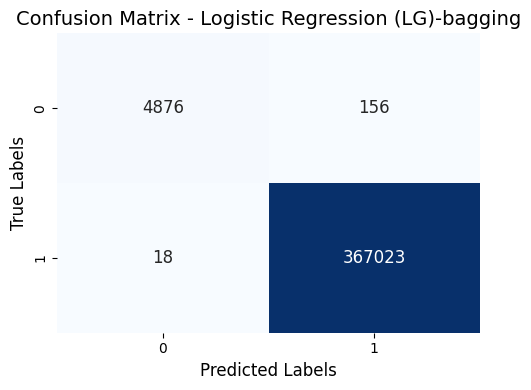

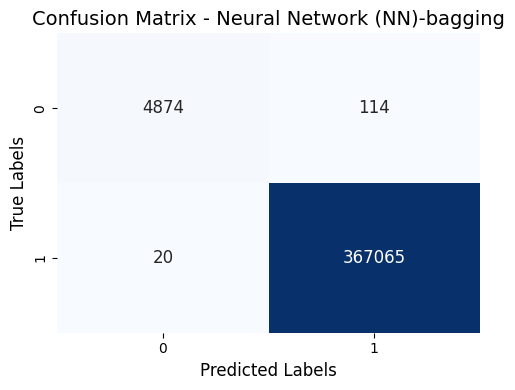

In [ ]:

# Bagging and stakcing， A，FERBL curve

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

model_names = ['SVM-Bagging', 'Logistic Regression-Bagging', 'Neural Network-Bagging', 'Stacking']
precisions = [0.94663, 0.96841, 0.97694, 0.98126]
sensitivities = [0.99673, 0.99550, 0.99550,0.99632]
accuracies = [0.99927, 0.99955, 0.99966, 0.98266]
Fscores = [0.97316, 0.98340, 0.98747, 0.9894]


x = np.arange(len(model_names))
width = 0.2


plt.figure(figsize=(12, 6))
plt.bar(x - 1.5*width, precisions, width, label='Precision', color='blue')
plt.bar(x - 0.5*width, sensitivities, width, label='Sensitivity', color='green')
plt.bar(x + 0.5*width, accuracies, width, label='Accuracy', color='red')
plt.bar(x + 1.5*width, Fscores, width, label='F1-Score', color='orange')


for i in range(len(model_names)):
    plt.text(x[i] - 1.5*width, precisions[i] + 0.005, f"{precisions[i]:.5f}", ha='center', va='bottom', fontsize=8)
    plt.text(x[i] - 0.5*width, sensitivities[i] + 0.005, f"{sensitivities[i]:.5f}", ha='center', va='bottom', fontsize=8)
    plt.text(x[i] + 0.5*width, accuracies[i] + 0.005, f"{accuracies[i]:.5f}", ha='center', va='bottom', fontsize=8)
    plt.text(x[i] + 1.5*width, Fscores[i] + 0.005, f"{Fscores[i]:.5f}", ha='center', va='bottom', fontsize=8)


plt.xticks(x, model_names, fontsize=10)
plt.xlabel("Models", fontsize=12)
plt.ylabel("Scores", fontsize=12)
plt.title("Comparison of Bagging and Stacking Metrics", fontsize=14)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=10)
plt.tight_layout()
plt.show()

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example confusion matrix for SVM, LG, and NN
# Replace these with your actual cumulative confusion matrix values
cumulative_cm_svm = np.array([[4878, 233], [16, 366946]])
cumulative_cm_lg = np.array([[4876, 156], [18, 367023]])
cumulative_cm_nn = np.array([[4874, 114], [20, 367065]])


# Function to plot a confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False, annot_kws={"size": 12})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14)
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot confusion matrices for each model
plot_confusion_matrix(cumulative_cm_svm, "SVM-bagging")
plot_confusion_matrix(cumulative_cm_lg, "Logistic Regression (LG)-bagging")
plot_confusion_matrix(cumulative_cm_nn, "Neural Network (NN)-bagging")




BASE LEARNERS CLASSIFICATION PERFORMANCE:
Model: svm, Param_1: rbf, tuning range: 0.001
Precision: 0.3201699575106223
Sensitivity (Recall): 0.9857637552904963
F-score: 0.48335062729931144
Accuracy: 0.9849081039376154
No_false: 5477
Confusion Matrix:
[[354871   5440]
 [    37   2562]]

BASE LEARNERS CLASSIFICATION PERFORMANCE:
Model: lg, Param_1: l2, tuning range: 0.005
Precision: 0.5972947318462268
Sensitivity (Recall): 0.9684494036167757
F-score: 0.7388815499779833
Accuracy: 0.9950979581714474
No_false: 1779
Confusion Matrix:
[[358614   1697]
 [    82   2517]]

BASE LEARNERS CLASSIFICATION PERFORMANCE:
Model: nn, Param_1: relu, tuning range: 200


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Precision: 0.29500580720092917
Sensitivity (Recall): 0.9772989611388996
F-score: 0.45320724417878494
Accuracy: 0.9831115152517153
No_false: 6129
Confusion Matrix:
[[354241   6070]
 [    59   2540]]


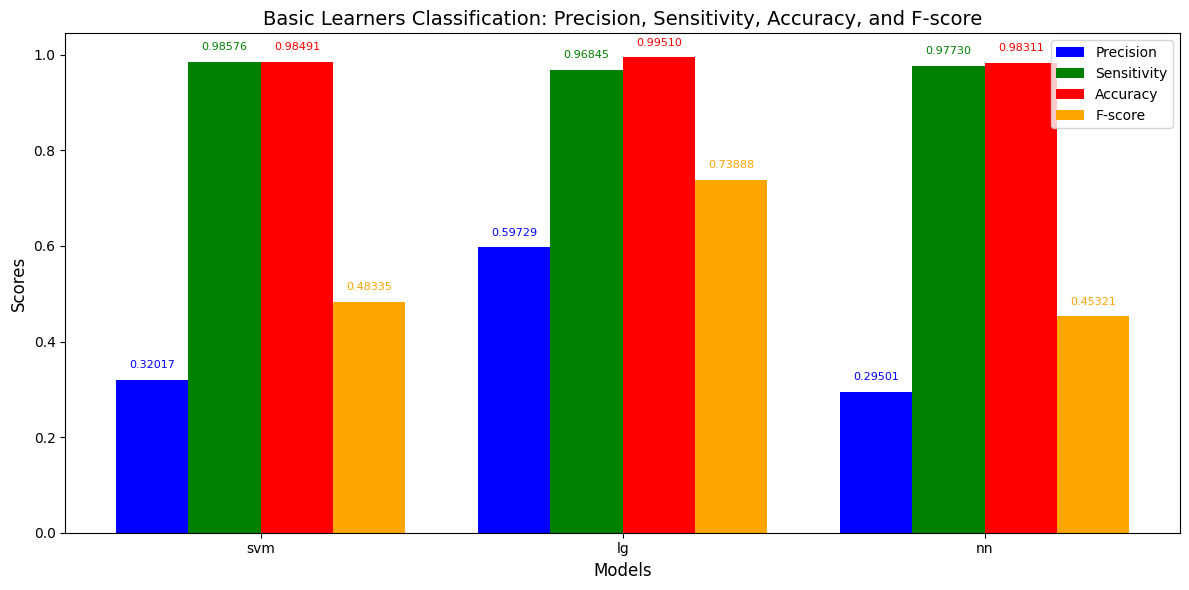

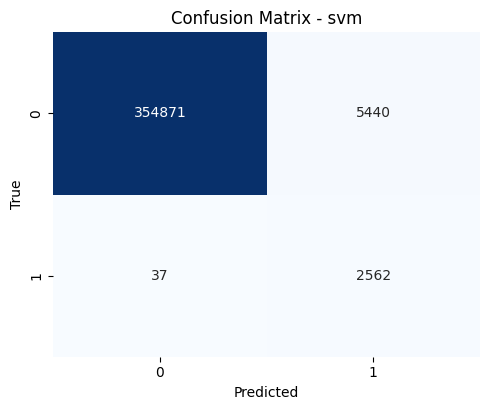

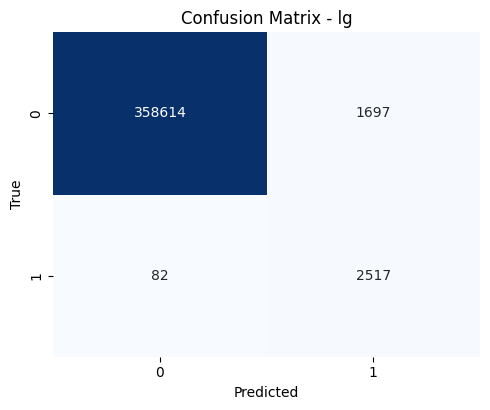

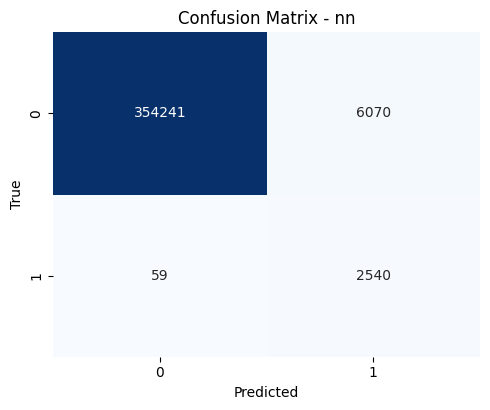

In [ ]:
# BASE LEARNERS CLASSIFICATION AND EVALUATION，Scheme B，ePBRN，curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

model_configs = [
    {'modeltype': 'svm', 'modeltype_2': 'rbf', 'param_range': 0.001},
    {'modeltype': 'lg', 'modeltype_2': 'l2', 'param_range': 0.005},
    {'modeltype': 'nn', 'modeltype_2': 'relu', 'param_range': 200}
]

# Initialize lists for plotting
model_names = []
precisions = []
sensitivities = []
Fscores = []
accuracies = []
confusion_matrices = []

# Base Learners Performance Evaluation
for config in model_configs:
    modeltype = config['modeltype']
    modeltype_2 = config['modeltype_2']
    modelparam_range = config['param_range']

    print("\nBASE LEARNERS CLASSIFICATION PERFORMANCE:")
    print(f"Model: {modeltype}, Param_1: {modeltype_2}, tuning range: {modelparam_range}")

    # Train and evaluate model on X_test
    md = train_model(modeltype, modelparam_range, X_train, y_train, modeltype_2)
    final_result = classify(md, X_test)
    final_eval = evaluation(y_test, final_result)

    # Append results for the current model
    precision = final_eval['precision']
    sensitivity = final_eval['sensitivity']
    Fscore = final_eval['F-score']
    nb_false = final_eval['no_false']
    acc = accuracy_score(y_test, final_result)

    precisions.append(precision)
    sensitivities.append(sensitivity)
    Fscores.append(Fscore)
    accuracies.append(acc)
    model_names.append(modeltype)

    # Generate confusion matrix
    cm = confusion_matrix(y_test, final_result)
    confusion_matrices.append(cm)

    # Print results
    print(f"Precision: {precision}")
    print(f"Sensitivity (Recall): {sensitivity}")
    print(f"F-score: {Fscore}")
    print(f"Accuracy: {acc}")
    print(f"No_false: {nb_false}")
    print(f"Confusion Matrix:\n{cm}")

# Plot Precision, Sensitivity, Accuracy, and F-score as bar charts
x = np.arange(len(model_names))
width = 0.2

plt.figure(figsize=(12, 6))

plt.bar(x - 1.5*width, precisions, width, label='Precision', color='blue')
plt.bar(x - 0.5*width, sensitivities, width, label='Sensitivity', color='green')
plt.bar(x + 0.5*width, accuracies, width, label='Accuracy', color='red')
plt.bar(x + 1.5*width, Fscores, width, label='F-score', color='orange')


for i in range(len(model_names)):
    # Precision
    plt.text(x[i] - 1.5*width, precisions[i] + 0.02, f"{precisions[i]:.5f}", ha='center', va='bottom', color='blue', fontsize=8)
    # Sensitivity，
    plt.text(x[i] - 0.5*width, sensitivities[i] + 0.02, f"{sensitivities[i]:.5f}", ha='center', va='bottom', color='green', fontsize=8)
    # Accuracy
    plt.text(x[i] + 0.5*width, accuracies[i] + 0.02, f"{accuracies[i]:.5f}", ha='center', va='bottom', color='red', fontsize=8)
    # F-score，
    plt.text(x[i] + 1.5*width, Fscores[i] + 0.02, f"{Fscores[i]:.5f}", ha='center', va='bottom', color='orange', fontsize=8)


plt.xticks(x, model_names, fontsize=10)
plt.xlabel("Models", fontsize=12)
plt.ylabel("Scores", fontsize=12)
plt.title("Basic Learners Classification: Precision, Sensitivity, Accuracy, and F-score", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


for i, cm in enumerate(confusion_matrices):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 10})
    plt.title(f"Confusion Matrix - {model_names[i]}", fontsize=12)
    plt.xlabel("Predicted", fontsize=10)
    plt.ylabel("True", fontsize=10)
    plt.tight_layout(rect=[0, -0.05, 1, 1])
    plt.show()

In [ ]:
# Bagging，Scheme B，ePBRN

print("BAGGING PERFORMANCE:\n")
n_folds = 10
kf = KFold(n_splits=n_folds)

model_configs = [
    {'modeltype': 'svm', 'modeltype_2': 'linear', 'param_range': 0.001},
    {'modeltype': 'lg', 'modeltype_2': 'l2', 'param_range': 0.005},
    {'modeltype': 'nn', 'modeltype_2': 'relu', 'param_range': 2000}
]
thres = 0.5
model_raw_scores = []


for config in model_configs:
    modeltype = config['modeltype']
    modeltype_2 = config['modeltype_2']
    modelparam_range = config['param_range']

    fold_precisions, fold_sensitivities, fold_fscores, fold_nb_false = [], [], [], []

    # KFold validation
    for n_folds, (train_index, valid_index) in enumerate(kf.split(X_train), start=1):
        X_train_fold = X_train[train_index]
        y_train_fold = y_train[train_index]
        md = train_model(modeltype, modelparam_range, X_train_fold, y_train_fold, modeltype_2)
        final_result = classify(md, X_test)
        final_eval = evaluation(y_test, final_result)

        model_raw_scores.append(final_result)

        fold_precisions.append(final_eval['precision'])
        fold_sensitivities.append(final_eval['sensitivity'])
        fold_fscores.append(final_eval['F-score'])
        fold_nb_false.append(final_eval['no_false'])
        print(f"Fold {n_folds} Results - Model: {modeltype}, Param: {modelparam_range}")
        print(modeltype, "bagging:", final_eval)



    avg_precision = np.mean(fold_precisions)
    avg_fscore = np.mean(fold_fscores)
    avg_nb_false = np.mean(fold_nb_false)

    print(f"Fold {n_folds} Results - Model: {modeltype}, Param: {modelparam_range}")
    print(f"  Precision: {final_eval['precision']}")
    print(f"  Sensitivity: {final_eval['sensitivity']}")
    print(f"  F-score: {final_eval['F-score']}")
    print(f"  No_false: {final_eval['no_false']}\n")

    bagging_raw_score = np.mean(model_raw_scores, axis=0)
    bagging_binary_score  = np.copy(bagging_raw_score)
    bagging_binary_score[bagging_binary_score > thres] = 1
    bagging_binary_score[bagging_binary_score <= thres] = 0
    bagging_eval = evaluation(y_test, bagging_binary_score)
    print(modeltype, "bagging:", bagging_eval)
    print('')




BAGGING PERFORMANCE:

Fold 1 Results - Model: svm, Param: 0.001
svm bagging: {'no_false': 1209, 'confusion_matrix': [2498, 1108, 101, 359203], 'precision': 0.6927343316694399, 'sensitivity': 0.9611388995767602, 'no_links': 3606, 'F-score': 0.805157131345689}
Fold 2 Results - Model: svm, Param: 0.001
svm bagging: {'no_false': 1209, 'confusion_matrix': [2498, 1108, 101, 359203], 'precision': 0.6927343316694399, 'sensitivity': 0.9611388995767602, 'no_links': 3606, 'F-score': 0.805157131345689}
Fold 3 Results - Model: svm, Param: 0.001
svm bagging: {'no_false': 1209, 'confusion_matrix': [2498, 1108, 101, 359203], 'precision': 0.6927343316694399, 'sensitivity': 0.9611388995767602, 'no_links': 3606, 'F-score': 0.805157131345689}
Fold 4 Results - Model: svm, Param: 0.001
svm bagging: {'no_false': 1209, 'confusion_matrix': [2498, 1108, 101, 359203], 'precision': 0.6927343316694399, 'sensitivity': 0.9611388995767602, 'no_links': 3606, 'F-score': 0.805157131345689}
Fold 5 Results - Model: svm, P

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre

Fold 5 Results - Model: lg, Param: 0.005
lg bagging: {'no_false': 1727, 'confusion_matrix': [2511, 1639, 88, 358672], 'precision': 0.6050602409638555, 'sensitivity': 0.966140823393613, 'no_links': 4150, 'F-score': 0.7441102385538598}
Fold 6 Results - Model: lg, Param: 0.005
lg bagging: {'no_false': 1698, 'confusion_matrix': [2510, 1609, 89, 358702], 'precision': 0.6093712066035446, 'sensitivity': 0.9657560600230858, 'no_links': 4119, 'F-score': 0.7472462042274487}
Fold 7 Results - Model: lg, Param: 0.005
lg bagging: {'no_false': 1746, 'confusion_matrix': [2517, 1664, 82, 358647], 'precision': 0.6020090887347525, 'sensitivity': 0.9684494036167757, 'no_links': 4181, 'F-score': 0.7424778761061946}
Fold 8 Results - Model: lg, Param: 0.005
lg bagging: {'no_false': 1749, 'confusion_matrix': [2517, 1667, 82, 358644], 'precision': 0.6015774378585086, 'sensitivity': 0.9684494036167757, 'no_links': 4184, 'F-score': 0.7421494913754975}
Fold 9 Results - Model: lg, Param: 0.005
lg bagging: {'no_fal

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre

lg bagging: {'no_false': 1209, 'confusion_matrix': [2498, 1108, 101, 359203], 'precision': 0.6927343316694399, 'sensitivity': 0.9611388995767602, 'no_links': 3606, 'F-score': 0.805157131345689}

Fold 1 Results - Model: nn, Param: 2000
nn bagging: {'no_false': 1204, 'confusion_matrix': [2507, 1112, 92, 359199], 'precision': 0.6927327991157778, 'sensitivity': 0.9646017699115044, 'no_links': 3619, 'F-score': 0.8063686072692182}
Fold 2 Results - Model: nn, Param: 2000
nn bagging: {'no_false': 1051, 'confusion_matrix': [2506, 958, 93, 359353], 'precision': 0.7234411085450346, 'sensitivity': 0.9642170065409773, 'no_links': 3464, 'F-score': 0.826653471878608}
Fold 3 Results - Model: nn, Param: 2000
nn bagging: {'no_false': 1232, 'confusion_matrix': [2508, 1141, 91, 359170], 'precision': 0.6873115922170457, 'sensitivity': 0.9649865332820315, 'no_links': 3649, 'F-score': 0.8028169014084506}
Fold 4 Results - Model: nn, Param: 2000
nn bagging: {'no_false': 1029, 'confusion_matrix': [2506, 936, 93

BAGGING + STACKING PERFORMANCE:

Processing Bagging for Model: svm, Param: 0.001
Processing Bagging for Model: lg, Param: 0.005


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre

Processing Bagging for Model: nn, Param: 2000
Stacking Features Shape (Train): (6384, 3)
Stacking Features Shape (Test): (362910, 3)

STACKING FINAL PERFORMANCE:
Accuracy: 0.995417596649307
Precision: 0.6145935357492655
Sensitivity (Recall): 0.9657560600230858
F1-Score: 0.7511596588358521
Confusion Matrix:
[[358737   1574]
 [    89   2510]]


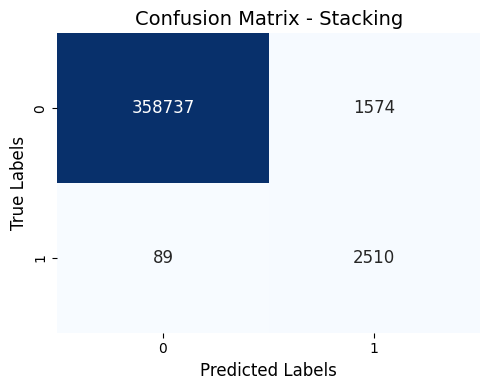

In [ ]:
#  stakcing
from xgboost import XGBClassifier

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

print("BAGGING + STACKING PERFORMANCE:\n")


model_configs = [
    {'modeltype': 'svm', 'modeltype_2': 'linear', 'param_range': 0.001},
    {'modeltype': 'lg', 'modeltype_2': 'l2', 'param_range': 0.005},
    {'modeltype': 'nn', 'modeltype_2': 'relu', 'param_range': 2000}
]

n_folds = 10
kf = KFold(n_splits=n_folds)
threshold = 0.99

stacking_features_train = []
stacking_features_test = []


for config in model_configs:
    modeltype = config['modeltype']
    modeltype_2 = config['modeltype_2']
    modelparam_range = config['param_range']

    print(f"Processing Bagging for Model: {modeltype}, Param: {modelparam_range}")

    bagging_raw_scores_test = []
    fold_valid_preds = np.zeros(X_train.shape[0])

    for n_folds, (train_index, valid_index) in enumerate(kf.split(X_train), start=1):
        X_train_fold, X_valid_fold = X_train[train_index], X_train[valid_index]
        y_train_fold, y_valid_fold = y_train[train_index], y_train[valid_index]

        md = train_model(modeltype, modelparam_range, X_train_fold, y_train_fold, modeltype_2)

        valid_preds = classify(md, X_valid_fold)
        fold_valid_preds[valid_index] = valid_preds

        test_preds = classify(md, X_test)
        bagging_raw_scores_test.append(test_preds)

    bagging_raw_score_test = np.mean(bagging_raw_scores_test, axis=0)

    stacking_features_train.append(fold_valid_preds)
    stacking_features_test.append(bagging_raw_score_test)


stacking_features_train = np.column_stack(stacking_features_train)
stacking_features_test = np.column_stack(stacking_features_test)

print("Stacking Features Shape (Train):", stacking_features_train.shape)
print("Stacking Features Shape (Test):", stacking_features_test.shape)

meta_learner = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)


meta_learner.fit(stacking_features_train, y_train)


y_pred_probs = meta_learner.predict_proba(stacking_features_test)[:, 1]



meta_learner.fit(stacking_features_train, y_train)


y_pred = meta_learner.predict(stacking_features_test)

threshold = 0.99
y_pred = np.where(y_pred_probs > threshold, 1, 0)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nSTACKING FINAL PERFORMANCE:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Sensitivity (Recall): {recall}")
print(f"F1-Score: {f1}")

cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}")

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 12})
plt.title('Confusion Matrix - Stacking', fontsize=14)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.tight_layout()
plt.show()


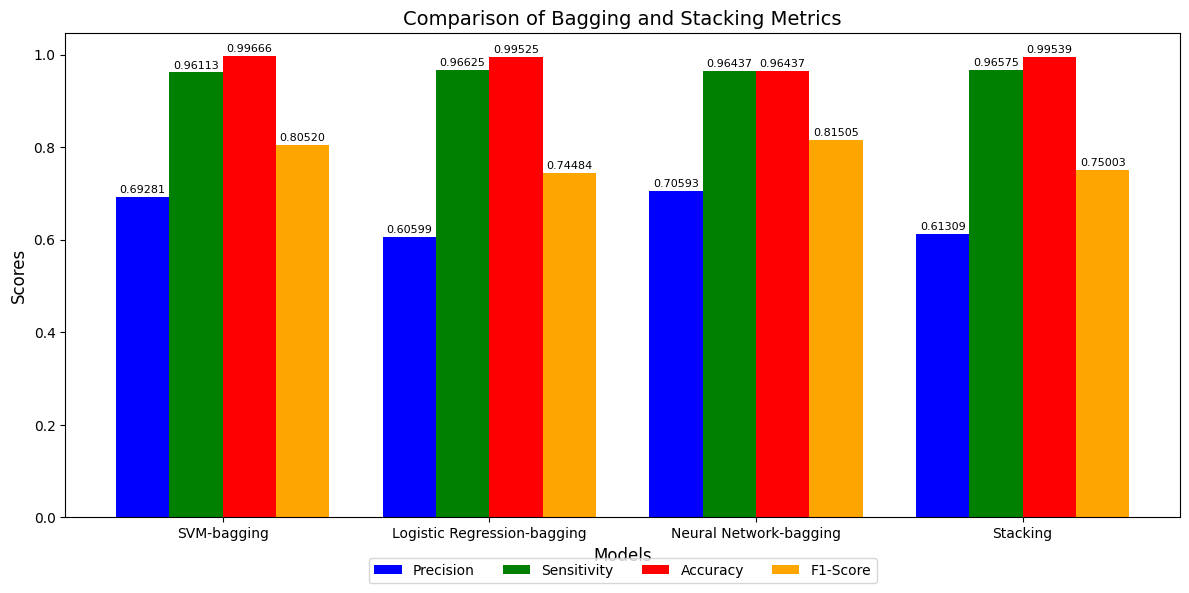

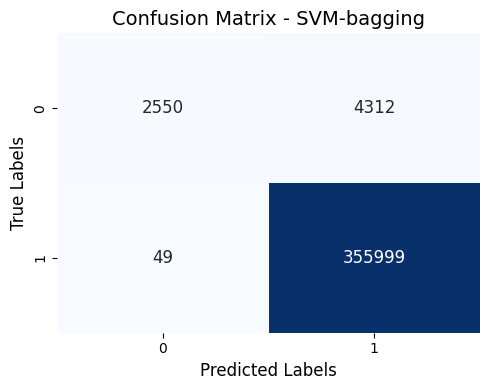

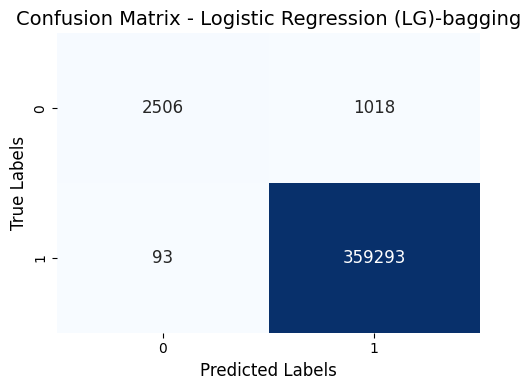

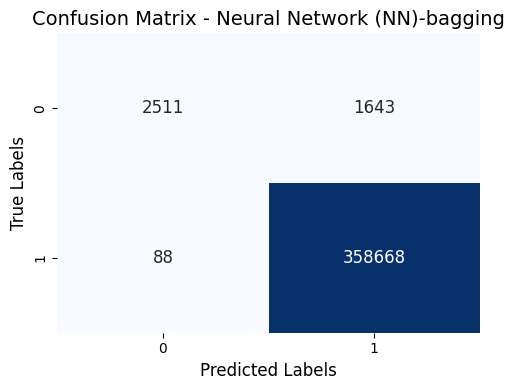

In [ ]:
## Bagging and stacking，Scheme B，ePBRN,curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

model_names = ['SVM-bagging', 'Logistic Regression-bagging', 'Neural Network-bagging', 'Stacking']
precisions = [0.69281, 0.60599,0.70593, 0.61309]
sensitivities = [0.96113, 0.96625, 0.96437,0.96575]
accuracies = [0.99666, 0.99525, 0.96437,0.99539]
Fscores = [0.80520, 0.74484, 0.81505, 0.75003]


x = np.arange(len(model_names))
width = 0.2


plt.figure(figsize=(12, 6))
plt.bar(x - 1.5*width, precisions, width, label='Precision', color='blue')
plt.bar(x - 0.5*width, sensitivities, width, label='Sensitivity', color='green')
plt.bar(x + 0.5*width, accuracies, width, label='Accuracy', color='red')
plt.bar(x + 1.5*width, Fscores, width, label='F1-Score', color='orange')


for i in range(len(model_names)):
    plt.text(x[i] - 1.5*width, precisions[i] + 0.005, f"{precisions[i]:.5f}", ha='center', va='bottom', fontsize=8)
    plt.text(x[i] - 0.5*width, sensitivities[i] + 0.005, f"{sensitivities[i]:.5f}", ha='center', va='bottom', fontsize=8)
    plt.text(x[i] + 0.5*width, accuracies[i] + 0.005, f"{accuracies[i]:.5f}", ha='center', va='bottom', fontsize=8)
    plt.text(x[i] + 1.5*width, Fscores[i] + 0.005, f"{Fscores[i]:.5f}", ha='center', va='bottom', fontsize=8)


plt.xticks(x, model_names, fontsize=10)
plt.xlabel("Models", fontsize=12)
plt.ylabel("Scores", fontsize=12)
plt.title("Comparison of Bagging and Stacking Metrics", fontsize=14)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=10)
plt.tight_layout()
plt.show()

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example confusion matrix for SVM, LG, and NN
# Replace these with your actual cumulative confusion matrix values
cumulative_cm_svm = np.array([[2550, 4312], [49, 355999]])
cumulative_cm_lg = np.array([[2506, 1018], [93, 359293]])
cumulative_cm_nn = np.array([[2511, 1643], [88, 358668]])


# Function to plot a confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False, annot_kws={"size": 12})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14)
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot confusion matrices for each model
plot_confusion_matrix(cumulative_cm_svm, "SVM-bagging")
plot_confusion_matrix(cumulative_cm_lg, "Logistic Regression (LG)-bagging")
plot_confusion_matrix(cumulative_cm_nn, "Neural Network (NN)-bagging")



